In [3]:
import pandas as pd
# import pandasql as ps
import matplotlib.pyplot as plt
# Import argsort
from numpy import argsort
from Functions.connection.connection import *
from Functions.AlertP1.data_cleaning import *
from Functions.AlertP1.features import *
from Functions.analysis.step_analysis import *
from Functions.AlertP1.dummy_features import *
from Functions.Models.decision_tree import *
from Functions.Models.Logistic_regression import *
from Functions.Models.evaluation import *



In [2]:
creds = pd.read_csv('/Users/MarouanKamoun/Desktop/HGO pbl/credentials.csv')

## Connection to databse

In [3]:
#Connection to the database
alertP1=connection(creds)

Tables: [('ConsultaUrgencia_doentespedidosconsultaNeurologia2012',), ('consultaneurologia2012',), ('consultaneurologia201216anon_true',)]
1073


## Data cleaning

In [4]:
#changing columns with date to a datetime
date_format_alertP1(alertP1)
#change the blank values in proveniencia and priority to unknown
replace_blank(alertP1)
#create a column with the output of a referral and select the refused and accepted ones
alertP1=result(alertP1)

c:\Users\MarouanKamoun\Desktop\HGO pbl\PBL-HGO\PBL-HGO\Functions\AlertP1\data_cleaning.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['PROVENIENCIA'][alertP1['PROVENIENCIA']=='']='unknown'
c:\Users\MarouanKamoun\Desktop\HGO pbl\PBL-HGO\PBL-HGO\Functions\AlertP1\data_cleaning.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['CTH_PRIOR'][alertP1['CTH_PRIOR']=='']='unknown'


## Creating new columns for features 

In [5]:
class_area(alertP1)
text_lenght(alertP1)
referral_steps(alertP1)
class_speciality(alertP1)
alertP1=unit(alertP1)



c:\Users\MarouanKamoun\Desktop\HGO pbl\PBL-HGO\PBL-HGO\Functions\AlertP1\features.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['step'][alertP1['step']>=3]='3+'
c:\Users\MarouanKamoun\Desktop\HGO pbl\PBL-HGO\PBL-HGO\Functions\AlertP1\features.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alertP1['unit'][alertP1['TIPO_UNID']!='CS/USF']='HOSP'


In [6]:
step_acceptance_rate(alertP1)

,step,number_of_acceptance,percentage
0,1,5168,66.0
1,2,936,74.0
2,3+,150,72.0


## structured data with dummies

In [7]:
data=structured_data_dummies(alertP1)

## Logistic regression for all dataset

features and coefficients

In [10]:
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['text_length','ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features=X.columns
#log_regression is defined in functions
y_pred,coefficients,intercept,X_train, X_test, y_train, y_test=log_regression(X,y)
df = pd.DataFrame(features, columns =['Feature'])
df['coefficients']=coefficients.T
df


,Feature,coefficients
0,outside area,-0.397390
1,SAM,0.256711
2,SON,-1.471326
3,unknown,-0.835323
4,DOENCAS DO MOVIMENTO,1.293239
5,DVC,0.004581
6,EPILEPSIA,0.689475
7,NEUROLOGIA,-3.128362
8,NEUROLOGIA - CEFALEIAS,0.031759
9,NEUROLOGIA - ESCLEROSE MULTIPLA,0.325554


metrics

Accuracy: 0.7381209503239741
Recall: 0.6140035199600202
Precision: 0.7209213279122093
              precision    recall  f1-score   support

     refused       0.70      0.28      0.40       578
    accepted       0.74      0.94      0.83      1274

    accuracy                           0.74      1852
   macro avg       0.72      0.61      0.62      1852
weighted avg       0.73      0.74      0.70      1852



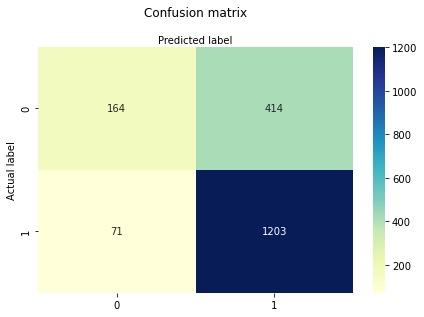

In [11]:
# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))

,Feature,p_value
0,outside area,0.000000e+00
1,SAM,4.163195e-15
2,SON,0.000000e+00
3,unknown,0.000000e+00
4,Other specialities,0.000000e+00
5,2,7.847168e-08
6,3+,1.862702e-01
7,HOSP,0.000000e+00
8,UCSP,1.485419e-02
9,USF,0.000000e+00


c:\Users\MarouanKamoun\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 1.59083182e-03  4.61962443e-01  1.09541725e-02 -1.60006246e-01
  -8.22520116e-01  3.24291221e+00  1.46265389e-01  3.57400371e-01
  -9.71572190e-01 -3.52157122e-01  1.43901605e-01]] [0.23736225]
Accuracy of the train set: 0.7372947615324472
Recall of the train set: 0.6553333445892708
Precision of the train set: 0.6983645850552325
Accuracy: 0.753125
Recall: 0.6646643783371472
Precision: 0.695373041461621
              precision    recall  f1-score   support

     refused       0.59      0.46      0.52        92
    accepted       0.80      0.87      0.83       228

    accuracy                           0.75       320
   macro avg       0.70      0.66      0.67       320
weighted avg       0.74      0.75      0.74       320



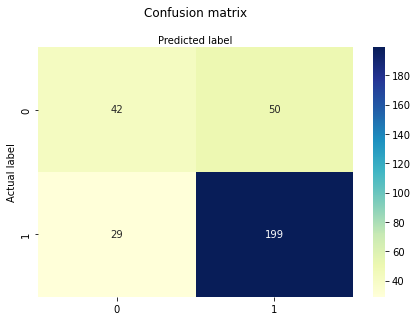

In [ ]:
#logistic regression text rows
data=data[data['text_length']>0]
#split dataset in features and target variable// Question: is it the right option?
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2,random_state=16)

# instantiate the model (using the default parameters)
logreg = LogisticRegression(random_state=16)

# fit the model with data
clf=logreg.fit(X_train, y_train)
print(clf.coef_, clf.intercept_)
y_pred = logreg.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, logreg.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,logreg.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, logreg.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)
# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cnf_matrix = confusion_matrix(y_test, y_pred)


class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)
# create heatmap
sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
# Print the evaluation matrix
target_names = ['refused', 'accepted']
print(classification_report(y_test, y_pred, target_names=target_names))


In [ ]:
#p value 
from sklearn.feature_selection import f_classif
# Calculate the p-value for each feature
f_values, p_values = f_classif(X, y)
features = X.columns
df = pd.DataFrame(features, columns =['Feature'])
df['p_value']=p_values
df

,Feature,p_value
0,text_length,2.568252e-30
1,outside area,4.194272e-27
2,SAM,1.991165e-04
3,SON,1.331836e-03
4,unknown,2.500977e-32
5,Other specialities,3.218134e-23
6,2,3.039005e-02
7,3+,1.573231e-01
8,HOSP,1.798069e-33
9,UCSP,1.727416e-01


In [ ]:
# Decision Tree classification model for whole dataset

from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report

#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto', 'text_length']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features = list(X.columns)
# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data[feature_cols] # Features
# y = data.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, logreg.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,logreg.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, logreg.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['refused', 'accepted'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))

ValueError: X has 10 features per sample; expecting 11

Accuracy of the train set: 0.7388584831899921
Recall of the train set: 0.6501435128730184
Precision of the train set: 0.6905978006892926
Accuracy: 0.75
Recall: 0.6705101327742837
Precision: 0.73828125


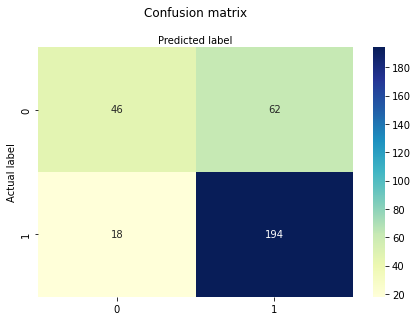

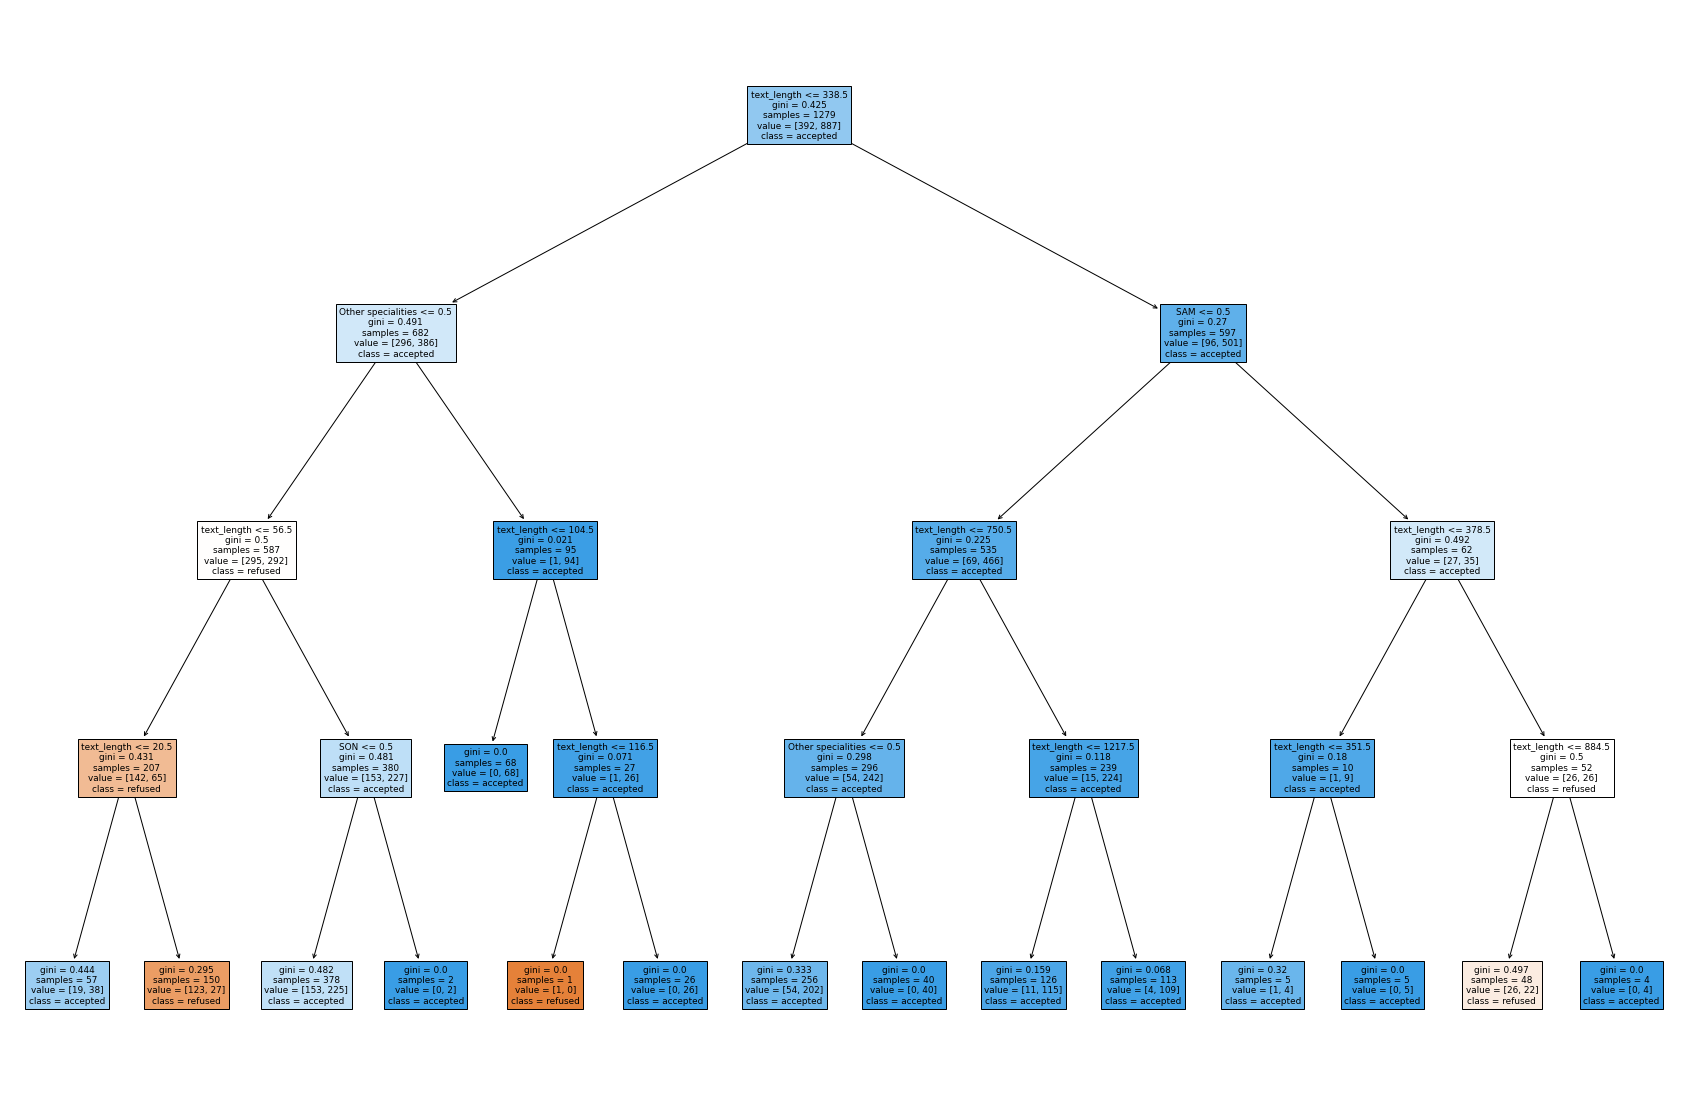

              precision    recall  f1-score   support

    accepted       0.72      0.43      0.53       108
     refused       0.76      0.92      0.83       212

    accuracy                           0.75       320
   macro avg       0.74      0.67      0.68       320
weighted avg       0.74      0.75      0.73       320



In [ ]:
# Decision Tree classification model for text rows
data=data[data['text_length']>0]
#split dataset in features and target variable
eliminate_cols=['ID_DOENTE','PROCESSO','COD_REFERENCIA','result','COD_PZ','COD_UNID_SAUDE_PROV','UNID_PROV','TIPO_UNID','COD_CTH_PRIOR','CTH_PRIOR','COD_MOTIVO_RECUSA','DES_MOTIVO_RECUSA','COD_ESPECIALIDADE','DES_ESPECIALIDADE','agrupadora','OUTRA_ENTIDADE','DATA_RECEPCAO','DATA_ENVIO','DATA_RETORNO','NUM_TAXA','ESTADO','DATA_MARCACAO','DATA_REALIZACAO','OBSERVACOES','Mês_entrada','Ano_entrada','trata data recusa','resume saída','mês_saida','ano_saida','Texto']
X = data.drop(eliminate_cols,axis=1)# Features
y = data.result # Target variable
features = list(X.columns)
# feature_cols = ['text_length','outside area','SAM','SON','unknown','Other specialities']
# X = data[feature_cols] # Features
# y = data.result # Target variable

# Split the dataset into training and testing subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a decision tree classifier
clf = DecisionTreeClassifier(max_depth=4, random_state = 42)
clf.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = clf.predict(X_test)

# Evaluate the accuracy of the train set
accuracy = accuracy_score(y_train, logreg.predict(X_train))
print("Accuracy of the train set:", accuracy)

# Evaluate the recall of the train set
recall = recall_score(y_train,logreg.predict(X_train), average='macro')
print("Recall of the train set:", recall)
# Evaluate the precision of the train set
precision = precision_score(y_train, logreg.predict(X_train), average='macro')
print("Precision of the train set:", precision)


# Evaluate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

# Evaluate the recall of the model
recall = recall_score(y_test, y_pred, average='macro')
print("Recall:", recall)

# Evaluate the precision of the model
precision = precision_score(y_test, y_pred, average='macro')
print("Precision:", precision)

# Calculate the confusion matrix of the model
cm = confusion_matrix(y_test, y_pred)

class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# create heatmap
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

# Visualize the decision tree
plt.figure(figsize=(30, 20))
plot_tree(clf, feature_names= features, class_names=['refused', 'accepted'], filled=True)
plt.show()

# Print the evaluation matrix
target_names = ['accepted', 'refused']
print(classification_report(y_test, y_pred, target_names=target_names))